## Imports

In [32]:
import gym # openAi gym
from gym import envs
import numpy as np 
from numpy import linalg as LA
import datetime
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from time import sleep


from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import os
from collections import deque

In [45]:
!pip install keras
!pip install tensorflow
!pip install keras-rl
!conda install -c conda-forge gym-box2d
!sudo apt install cmake libz-dev # atari-py depends on cmake if its not installed atari-py installation will fail
!pip install atari-py
!pip install nes-py
!pip install gym-super-mario-bros

keras-rl implements some state-of-the art deep reinforcement learning algorithms in Python and seamlessly integrates with the deep learning library Keras.

Furthermore, keras-rl works with OpenAI Gym out of the box. This means that evaluating and playing around with different algorithms is easy.

## What is Reinforcement Learning?

![image info](./images/rl_loop.png)

Model based Value Iteration Algorithm 
Model free Q Learning

https://arxiv.org/pdf/1312.5602.pdf

### Markov decision Process

The word Markov refers to Markovian property which means that the state is independent of any previous states history, not on the sequence of events that preceded it. The current state encapsulates all that is needed to decide the future actions, no memory needed.

In terms of Reinforcement Learning the Environment is modeled as a markov model and the agent needs to take actions in this environment to maximize the amount of reward. Since the agent sees only the outside of the environment (the effects of it actions) it is often referred to as the hidden markov model which needs to be learned.

#### Policy

Policy (π): The strategy that the agent employs to determine next action 'a' in state 's'. Note that it does not state if it is a good or bad policy, it is a policy. The policy is normally noted with the greek letter π. Optimal policy (π*), policy which maximizes the expected reward. Among all the policies taken, the optimal policy is the one that optimizes to maximize the amount of reward received or expected to receive over a lifetime.

#### Bellman Equation

![image info](./images/bellman_equation.svg)

- R(s,a) = Reward of action a in state s
- P(s'|s,a)= Probability of going to state s' given action a in state s. The Taxi game actions are deterministic (no such a thing as if I want to go north there is an 80% chance to go north and 10% chance to go west and 10% chance to go east). so the probability that selected action will lead to expected state is 100%. So ignore it for this game, it is always 1.
- γ = Discount factor gamma, how much discount is applicable for the future rewards. It must be between 0 and 1. The higher gamma the higher the focus on long term rewards

The value iteration algorithm makes use of the equation in the form of:

- Value V(s): The expected long-term return with discount, as opposed to the short-term reward R. Vπ(s) is defined as the expected long-term return of the current state sunder policy π.
The Q learning algorithm makes use of the equation in the form of:

- Q-matrix or action-value Q(s,a): Q-matrix is similar to Value, except that it takes an extra parameter, the action a. Qπ(s, a) refers to the long-term return of the current state s, taking action a under policy π.

#### Value Iteration Algorithm

The value iteration is centred around the game states. The core of the idea is to calculate the value (expected long-term maximum result) of each state. The algorithm loops over all states (s) and possible actions (a) to explore rewards of a given action and calculates the maximum possible action/reward and stores it in V[s]. The algorithm iterates/repeats until V[s] is not (significantly) improving anymore. 

The Optimal policy (π*) is then to take every time the action to go state with the highest value. This value iteration algorithm is an example of what is referred to as dynamic programming (DP) in literature. There are other DP techniques to solve this like policy iteration, etc but it can also be solved by a recursive program (a function that calls itself, look at the Bellman equation, it is a recursive definition).

### Q-Learning

Centered around the agent and starts exploring based on trial-and-error to update its knowledge about the model and hence path to the best reward. The core of the idea is the Q-matrix 
- Q(s, a). It contains the maximum discounted future reward when we perform action a in state s. Or in other words Q(s, a) gives estimates the best course of action a in state s. Q-learning learns by trail and error and updates its policy (Q-matrix) based on reward. to state it simple: the best it can do given a state it is in.

After every step we update Q(s,a) using the reward, and the max Q value for new state resulting from the action. 

This update is done using the action value formula, based upon the Bellman equation and allows state-action pairs to be updated in a recursive fashion (based on future values).

The Bellman equation is extended with a learning rate alpha:

![image info](./images/q_learning_bellman.png)

If alpha is set to 1, we return to the original Bellman equation.

The Q-matrix is initialized with zero's. So initially it starts moving randomly until it hits a state/action with rewards or state/actions with a penalty. For understanding, let's simplify the problem that it needs to go to a certain drop-off position to get a reward. So random moves get no rewards but by luck (brute force enough tries) the state/action is found where a reward is given. So next game the immediate actions preceding this state/action will direct toward it by use of the Q-Matrix. The next iteration the actions before that, etc, etc. In other words, it solves "the puzzle" backwards from end-result (drop-off passenger) towards steps to be taken to get there in a iterative fashion.


#### Exploration vs Exploitation

- Exploitation: Make the best decision given current information available (Go to the restaurant you know you like)
- Exploration: Gather more information (go to a new restaurant to find out if you like it)

Some approaches for this tradeoff:

- Epsilon Greedy: We exploit the current situation with probability 1 — epsilon and explore a new option with probability epsilon, the rates of exploration and exploitation are fixed
- Epsilon-Decreasing: We exploit the current situation with probability 1 — epsilon and explore a new option with probability epsilon, with epsilon decreasing over time.
- Thompson sampling: the rates of exploration and exploitation are dynamically updated with respect to the entire probability distribution of each arm
- Epsilon-Decreasing with Softmax: We exploit the current situation with probability 1 — epsilon and explore a new option with probability epsilon, with epsilon decreasing over time. In the case of exploring a new option, we don’t just pick an option at random, but instead we estimate the outcome of each option, and then pick based on that, this is the softmax part.

### Deep Reinforcement Learning

Imagine you got a full Atari game screen of pixels as an observation and it becomes quickly visible the Q-matrix solution will not cope. Also the Q-learning agent does not have the ability to estimate value for unseen states, it has no clue which action to take and goes back to random action as best.

To deal with these problems, Deep Q-Network (DQN) removes the two-dimensional Q-matrix by introducing a Neural Network. So it leverages a Neural Network to estimate the Q-value function. The input for the network is the current game state, while the output is the corresponding Q-value for each of the actions.

In 2014 Google DeepMind published a paper titled "Playing Atari with Deep Reinforcement Learning" that can play Atari 2600 games at expert human levels. This was the first breakthruogh in applying deep neural networks for reinforcement learning.

![image info](./images/atari_dqn.png)

## OpenAI Gym

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

![image info](./images/rl_gym_loop.png)

Each timestep, the agent chooses an action, and the environment returns an observation and a reward.

observation, reward, done, info = env.step(action)

- observation (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game line Taxi.
- reward (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
- done (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
- info (dict): ignore, diagnostic information useful for debugging. Official evaluations of your agent are not allowed to use this for learning.

There are a lot of different video game environments for testing Reinforcement Learning algorithms in different scenarios. Currently the number of different environments available in Python Gym is 859

Some of the environments available are:

Taxi, Mountaincar, InvertedPendulum, MarioBros, Taxi

In [6]:
print(len(envs.registry.all()))

859


#### Actions

Action (a): the input the agent provides to the environment. So what are the action commands the agents can give to the enironment? The value of env.action_space gives us this information.

What is the meaning of the actions? For the deep learning algorithm it should not matter, it should sort it out independent of the meaning of the action. But for humans it is handy to have the description, so we can understand the actions.

#### States

State (s): This represents the board state of the game and in gym returned it is returned as observation. State: a numeric representation of what the agent is observing at a particular moment of time in the environment.
In case of Taxi the observation is an integer, 500 different states are possible that translate to a nice graphic visual format with the render function. Note that this is specific for the Taxi game, in case of e.g. an Atari game the observation is the game screen with many coloured pixels.

### Taxi v3

This task was introduced in [Dietterich2000] to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. Once the passenger is dropped off, the episode ends. The taxi cannot pass thru a wall.

Rewards: There is a reward of -1 for each action and an additional reward of +20 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters: locations

In [15]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



#### Agent action

There are 6 operations the "agent" can perform:

- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

In [19]:
# action space has 6 possible actions, the meaning of the actions is nice to know for us humans but the neural network will figure it out
print("Possible actions for agent in game Taxi: %a" % (env.action_space.n))

Possible actions for agent in game Taxi: 6


#### States

In [32]:
print(env.observation_space)
print()
env.env.s = 42 # random state
env.render()
env.env.s = 222 # random state
env.render()

Discrete(500)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


#### Model based approach - Value Iteration Algorithm

The Taxi game is an example of an Markov decision process . We can describe the game in states, possible actions in a statethat leading to a next state with a certain probability with a reward. In our case we will be solving the game via a value iteration algorithm using the Bellman equation described earlier. 

In [33]:
# Let's do some random steps in the game so we can see how the game looks like
env = gym.make('Taxi-v3')
env.reset()

reward = 0
obs = env.reset()
print("Initial state")
env.render()
for _ in range(3):
    action = env.action_space.sample() #take step using random action from possible actions (actio_space)
    obs, rew, done, info = env.step(action) 
    reward = reward + rew
    env.render()
#Final reward of these random actions

print("Reward: %r" % reward)    

Initial state
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Reward: -21


We will now apply our value iteration algorithm and analyze the results

In [34]:
# Value iteration algorithm

n_actions = env.action_space.n
n_states = env.observation_space.n
V = np.zeros([n_states]) # The Value for each state
Pi = np.zeros([n_states], dtype=int)  # Our policy with we keep updating to get the optimal policy
gamma = 0.9 # discount factor
significant_improvement = 0.01

def best_action_value(s):
    # finds the highest value action (max_a) in state s
    best_a = None
    best_value = float('-inf')

    # loop through all possible actions to find the best current action
    for a in range (0, n_actions):
        env.env.s = s
        s_new, rew, done, info = env.step(a) #take the action
        v = rew + gamma * V[s_new]
        if v > best_value:
            best_value = v
            best_a = a
    return best_a

iteration = 0
while True:
    # biggest_change is referred to by the mathematical symbol delta in equations
    biggest_change = 0
    for s in range (0, n_states):
        old_v = V[s]
        action = best_action_value(s) #choosing an action with the highest future reward
        env.env.s = s # goto the state
        s_new, rew, done, info = env.step(action) #take the action
        V[s] = rew + gamma * V[s_new] #Update Value for the state using Bellman equation
        Pi[s] = action
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))
    iteration += 1
    if biggest_change < significant_improvement:
        print('Finished in {} iterations'.format(iteration))
        break

Finished in 41 iterations


In [35]:
# Let's see how the algorithm solves the taxi game
reward = 0
obs = env.reset()
env.render()
done = False

while done != True: 
    action = Pi[obs]
    obs, rew, done, info = env.step(action) #take step using selected action
    reward = reward + rew
    env.render()
#Print the reward of these actions
print("Reward: %r" % reward)  

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |

#### Model free approach - Q-Learning

In [36]:
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros([n_states, n_actions]) #You could also make this dynamic if you don't know all games states upfront
gamma = 0.9 # discount factor
alpha = 0.9 # learning rate
for episode in range(1,1001):
    done = False
    rew_tot = 0
    obs = env.reset()
    while done != True:
            action = np.argmax(Q[obs]) #choosing the action with the highest Q value 
            obs2, rew, done, info = env.step(action) #take the action
            Q[obs,action] += alpha * (rew + gamma * np.max(Q[obs2]) - Q[obs,action]) #Update Q-matrix using Bellman equation
            #Q[obs,action] = rew + gamma * np.max(Q[obs2]) # same equation but with learning rate = 1 returns the basic Bellman equation
            rew_tot = rew_tot + rew
            obs = obs2   
    if episode % 50 == 0:
        print('Episode {} Total Reward: {}'.format(episode,rew_tot))

Episode 50 Total Reward: -200
Episode 100 Total Reward: -30
Episode 150 Total Reward: 10
Episode 200 Total Reward: -49
Episode 250 Total Reward: -3
Episode 300 Total Reward: 12
Episode 350 Total Reward: 7
Episode 400 Total Reward: 11
Episode 450 Total Reward: 6
Episode 500 Total Reward: 2
Episode 550 Total Reward: 6
Episode 600 Total Reward: 11
Episode 650 Total Reward: 8
Episode 700 Total Reward: 9
Episode 750 Total Reward: 11
Episode 800 Total Reward: 7
Episode 850 Total Reward: 1
Episode 900 Total Reward: 8
Episode 950 Total Reward: 9
Episode 1000 Total Reward: 9


In the case of the Taxi game there is a reward of -1 for each action. If the agent finds itself in a state where the algorithm explored "South" which let to no value the Q-matrix is updated to -1. The next iteration will try an action that is not yet tried and still on 0. This approach encourages a systematic exploration of states and actions.

If the learning rate alpha is set to 1 the Taxi game will be solved, the reason being that there is only one reward (dropoff passenger), so the algorithm will find it whatever learning rate. In the case of a game that has more reward places the learning rate will determine if it the agent should prioritize longer term or short term rewards.

In [38]:
# Let's see how the algorithm solves the taxi game by following the policy to take actions delivering max value
reward = 0
obs = env.reset()
env.render()
done = False
while done != True: 
    action = np.argmax(Q[obs])
    obs, rew, done, info = env.step(action) #take step using selected action
    reward = reward + rew
    env.render()
#Print the reward of these actions
print("Reward: %r" % reward)  

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: 

### Frozen lakes

"Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend."

- S: Start point
- F: Frozen zone
- H: Hole
- G: Goal where the frisbee has fallen

In this case we have a non-deterministic environment in which the description defines the frozen lake as "slippery" meaning that the decisions the agent takes won't follow one single calculated path.

In [39]:
env = gym.make('FrozenLake-v0')
reward = 0
obs = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [40]:
env = gym.make('FrozenLake-v0')
env.reset()

n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros([n_states, n_actions]) #You could also make this dynamic if you don't know all games states upfront

gamma = 0.95 # discount factor
alpha = 0.01 # learning rate
epsilon = 0.1 #

for episode in range(1,500001):
    done = False
    obs = env.reset()
    while done != True:
        if np.random.rand(1) < epsilon:
            # exploration with a new option with probability epsilon, the epsilon greedy approach
            action = env.action_space.sample()
        else:
            # exploitation
            action = np.argmax(Q[obs])
        obs2, rew, done, info = env.step(action) #take the action
        Q[obs,action] += alpha * (rew + gamma * np.max(Q[obs2]) - Q[obs,action]) #Update Q-matrix using Bellman equation
        obs = obs2   
        
    if episode % 5000 == 0:
        #report every 5000 steps, test 100 games to get avarage point score for statistics and verify if it is solved
        rew_average = 0.
        for i in range(100):
            obs= env.reset()
            done=False
            while done != True: 
                action = np.argmax(Q[obs])
                obs, rew, done, info = env.step(action) #take step using selected action
                rew_average += rew
        rew_average=rew_average/100
        print('Episode {} average reward: {}'.format(episode,rew_average))
        
        if rew_average > 0.8:
            # FrozenLake-v0 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.
            # Test it on 0.8 so it is not a one-off lucky shot solving it
            print("Frozen lake solved")
            break

Episode 5000 average reward: 0.0
Episode 10000 average reward: 0.0
Episode 15000 average reward: 0.03
Episode 20000 average reward: 0.1
Episode 25000 average reward: 0.16
Episode 30000 average reward: 0.68
Episode 35000 average reward: 0.56
Episode 40000 average reward: 0.75
Episode 45000 average reward: 0.74
Episode 50000 average reward: 0.71
Episode 55000 average reward: 0.77
Episode 60000 average reward: 0.74
Episode 65000 average reward: 0.74
Episode 70000 average reward: 0.85
Frozen lake solved


In [43]:
# Let's see how the algorithm solves the frozen-lakes game
env = gym.make('FrozenLake-v0')
env.reset()

reward = 0
obs = env.reset()
done = False

while done != True: 
    action = np.argmax(Q[obs])
    obs, rew, done, info = env.step(action) #take step using selected action
    reward += rew
    env.render()

print("Final reward:", reward)  

  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 1.0


By analizing the moves we can see that if you want to move to the rigth, there is a significant chance you move up or down. Similarly if you want to move up, there is a significant chance you move left or right. The agent has learned that if you are on the frozen tile left column second row and you want to move down it is risky to give the down command because you could move to the right into the hole, so it gives the left command because it will keep it on the tile or move up or down, but not to the right. The agent has learned to take the actions with the least risk by accidently slipping and drowning in a hole.


It is very important to notice that this Q-Learning algorithm used thousands of iterations to find the optimal policy in a game that has a 4x4 environment

## Neural Nets Applied to Reinforcement Learning

### Inverted Pendulum

In [19]:
env = gym.make('CartPole-v1')
reward = 0
obs = env.reset()
env.render()
input("Press enter to close environment...")
env.close()

Press enter to close environment...


![image info](./images/inverted_pendulum.png)

In [3]:
print(env.action_space) # Discrete(2)
print(env.observation_space) # Box(4,)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


#### Random decision agent

In [4]:
# Global variables
num_episodes = 10
max_timestep = 1000
# The main program loop
for episode in range(num_episodes):
    observation = env.reset()
    # Iterating through time steps within an episode
    for t in range(max_timestep):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            # If the pole has tipped over, end this episode
            break
env.close()

#### Neural Network

In [35]:
class NNLayer:
    # class representing a neural net layer
    def __init__(self, input_size, output_size, activation=None, lr = 0.001):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.uniform(low=-0.5, high=0.5, size=(input_size, output_size))
        self.stored_weights = np.copy(self.weights)
        self.activation_function = activation
        self.lr = lr
        self.m = np.zeros((input_size, output_size))
        self.v = np.zeros((input_size, output_size))
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.time = 1
        self.adam_epsilon = 0.00000001

    # Compute the forward pass for this layer
    def forward(self, inputs, remember_for_backprop=True):
        # inputs has shape batch_size x layer_input_size 
        input_with_bias = np.append(inputs,1)
        unactivated = None
        if remember_for_backprop:
            unactivated = np.dot(input_with_bias, self.weights)
        else: 
            unactivated = np.dot(input_with_bias, self.stored_weights)
        # store variables for backward pass
        output = unactivated
        if self.activation_function != None:
            # assuming here the activation function is relu, this can be made more robust
            output = self.activation_function(output)
        if remember_for_backprop:
            self.backward_store_in = input_with_bias
            self.backward_store_out = np.copy(unactivated)
        return output    
        
    def update_weights(self, gradient):        
        m_temp = np.copy(self.m)
        v_temp = np.copy(self.v) 
        
        m_temp = self.beta_1*m_temp + (1-self.beta_1)*gradient
        v_temp = self.beta_2*v_temp + (1-self.beta_2)*(gradient*gradient)
        m_vec_hat = m_temp/(1-np.power(self.beta_1, self.time+0.1))
        v_vec_hat = v_temp/(1-np.power(self.beta_2, self.time+0.1))
        self.weights = self.weights - np.divide(self.lr*m_vec_hat, np.sqrt(v_vec_hat)+self.adam_epsilon)
        
        self.m = np.copy(m_temp)
        self.v = np.copy(v_temp)
        
    def update_stored_weights(self):
        self.stored_weights = np.copy(self.weights)
        
    def update_time(self):
        self.time = self.time+1
        
    def backward(self, gradient_from_above):
        adjusted_mul = gradient_from_above
        # this is pointwise
        if self.activation_function != None:
            adjusted_mul = np.multiply(relu_derivative(self.backward_store_out),gradient_from_above)
        D_i = np.dot(np.transpose(np.reshape(self.backward_store_in, (1, len(self.backward_store_in)))), np.reshape(adjusted_mul, (1,len(adjusted_mul))))
        delta_i = np.dot(adjusted_mul, np.transpose(self.weights))[:-1]
        self.update_weights(D_i)
        return delta_i

####  Custom Agent

In [36]:
class RLAgent:
    # class representing a reinforcement learning agent
    env = None
    def __init__(self, env, num_hidden_layers=2, hidden_size=24, gamma=0.95, epsilon_decay=0.997, epsilon_min=0.01):
        self.env = env
        self.hidden_size = hidden_size
        self.input_size = env.observation_space.shape[0]
        self.output_size = env.action_space.n
        self.num_hidden_layers = num_hidden_layers
        self.epsilon = 1.0
        self.epsilon_decay = 0.997
        self.epsilon_min = epsilon_min
        self.memory = deque([],1000000)
        self.gamma = gamma
        
        self.layers = [NNLayer(self.input_size + 1, self.hidden_size, activation=relu)]
        for i in range(self.num_hidden_layers-1):
            self.layers.append(NNLayer(self.hidden_size+1, self.hidden_size, activation=relu))
        self.layers.append(NNLayer(self.hidden_size+1, self.output_size))
        
    def select_action(self, observation):
        values = self.forward(np.asmatrix(observation))
        if (np.random.random() > self.epsilon):
            return np.argmax(values)
        else:
            return np.random.randint(self.env.action_space.n)
            
    def forward(self, observation, remember_for_backprop=True):
        vals = np.copy(observation)
        index = 0
        for layer in self.layers:
            vals = layer.forward(vals, remember_for_backprop)
            index = index + 1
        return vals
        
    def remember(self, done, action, observation, prev_obs):
        self.memory.append([done, action, observation, prev_obs])
        
    def experience_replay(self, update_size=20):
        if (len(self.memory) < update_size):
            return
        else: 
            batch_indices = np.random.choice(len(self.memory), update_size)
            for index in batch_indices:
                done, action_selected, new_obs, prev_obs = self.memory[index]
                action_values = self.forward(prev_obs, remember_for_backprop=True)
                next_action_values = self.forward(new_obs, remember_for_backprop=False)
                experimental_values = np.copy(action_values)
                if done:
                    experimental_values[action_selected] = -1
                else:
                    experimental_values[action_selected] = 1 + self.gamma*np.max(next_action_values)
                self.backward(action_values, experimental_values)
        self.epsilon = self.epsilon if self.epsilon < self.epsilon_min else self.epsilon*self.epsilon_decay
        for layer in self.layers:
            layer.update_time()
            layer.update_stored_weights()
        
    def backward(self, calculated_values, experimental_values): 
        # values are batched = batch_size x output_size
        delta = (calculated_values - experimental_values)
        # print('delta = {}'.format(delta))
        for layer in reversed(self.layers):
            delta = layer.backward(delta)

In [37]:
env = gym.make('CartPole-v1')

def relu(mat):
    return np.multiply(mat,(mat>0))
    
def relu_derivative(mat):
    return (mat>0)*1

#### InvertedPendulum training and execution

In [39]:
# Global variables
NUM_EPISODES = 10000
MAX_TIMESTEPS = 1000
AVERAGE_REWARD_TO_SOLVE = 195
NUM_EPS_TO_SOLVE = 100
NUM_RUNS = 20
GAMMA = 0.95
EPSILON_DECAY = 0.997
update_size = 10
hidden_layer_size = 24
num_hidden_layers = 2
model = RLAgent(env,num_hidden_layers,hidden_layer_size,GAMMA,EPSILON_DECAY)
scores_last_timesteps = deque([], NUM_EPS_TO_SOLVE)


# The main program loop
for i_episode in range(NUM_EPISODES):
    observation = env.reset()
    if i_episode >= NUM_EPS_TO_SOLVE:
        if (sum(scores_last_timesteps)/NUM_EPS_TO_SOLVE > AVERAGE_REWARD_TO_SOLVE):
            print("solved after {} episodes".format(i_episode))
            break
    # Iterating through time steps within an episode
    for t in range(MAX_TIMESTEPS):
        env.render()
        action = model.select_action(observation)
        prev_obs = observation
        observation, reward, done, info = env.step(action)
        # Keep a store of the agent's experiences
        model.remember(done, action, observation, prev_obs)
        model.experience_replay(update_size)
        # epsilon decay
        if done:
            # If the pole has tipped over, end this episode
            scores_last_timesteps.append(t+1)
            break
env.close()

## ATARI Games and Mario Bros

In [41]:
# # Set-up the virtual display environment
# !apt-get update
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install piglet
# !apt-get install ffmpeg -y

In [43]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

![image info](./images/mario_bros.png)

Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(4)


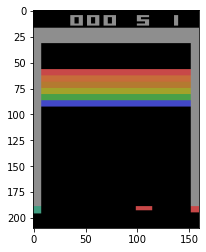

In [44]:
env = gym.make("BreakoutNoFrameskip-v4")
plt.imshow(env.render('rgb_array'))
plt.grid(False)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(9)


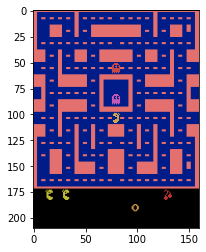

In [45]:
env = gym.make("MsPacmanNoFrameskip-v4")
plt.imshow(env.render('rgb_array'))
plt.grid(False)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)


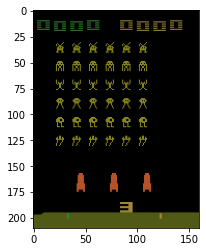

In [46]:
env = gym.make("SpaceInvadersNoFrameskip-v4")
plt.imshow(env.render('rgb_array'))
plt.grid(False)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

## Discussion